# House Prices - Advanced Regression Techniques

The task was forecasting prices of houses

Full task you can read there:   
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/description

In [1]:
import xgboost as xgb

#let's import neccery libraries
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import warnings
from sklearn.metrics import explained_variance_score
warnings.filterwarnings('ignore')
import xgboost as xg 
from sklearn.model_selection import train_test_split

In [2]:
#lets download train data
data = pd.read_csv('train.csv',na_values=[ '#N/A', '#N/A N/A', '#NA','-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NA','NULL', 'NaN', 'n/a', 'nan', 'null''None'])

In [3]:
#table size:
data.shape

(1460, 81)

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#let's see what part of data is missing.
y = (data.isnull().sum()/len(data))*100
y = y.drop(y[y==0.0].index)
y = y.sort_values(ascending = False)
x = list(range(0,len(y.index)))

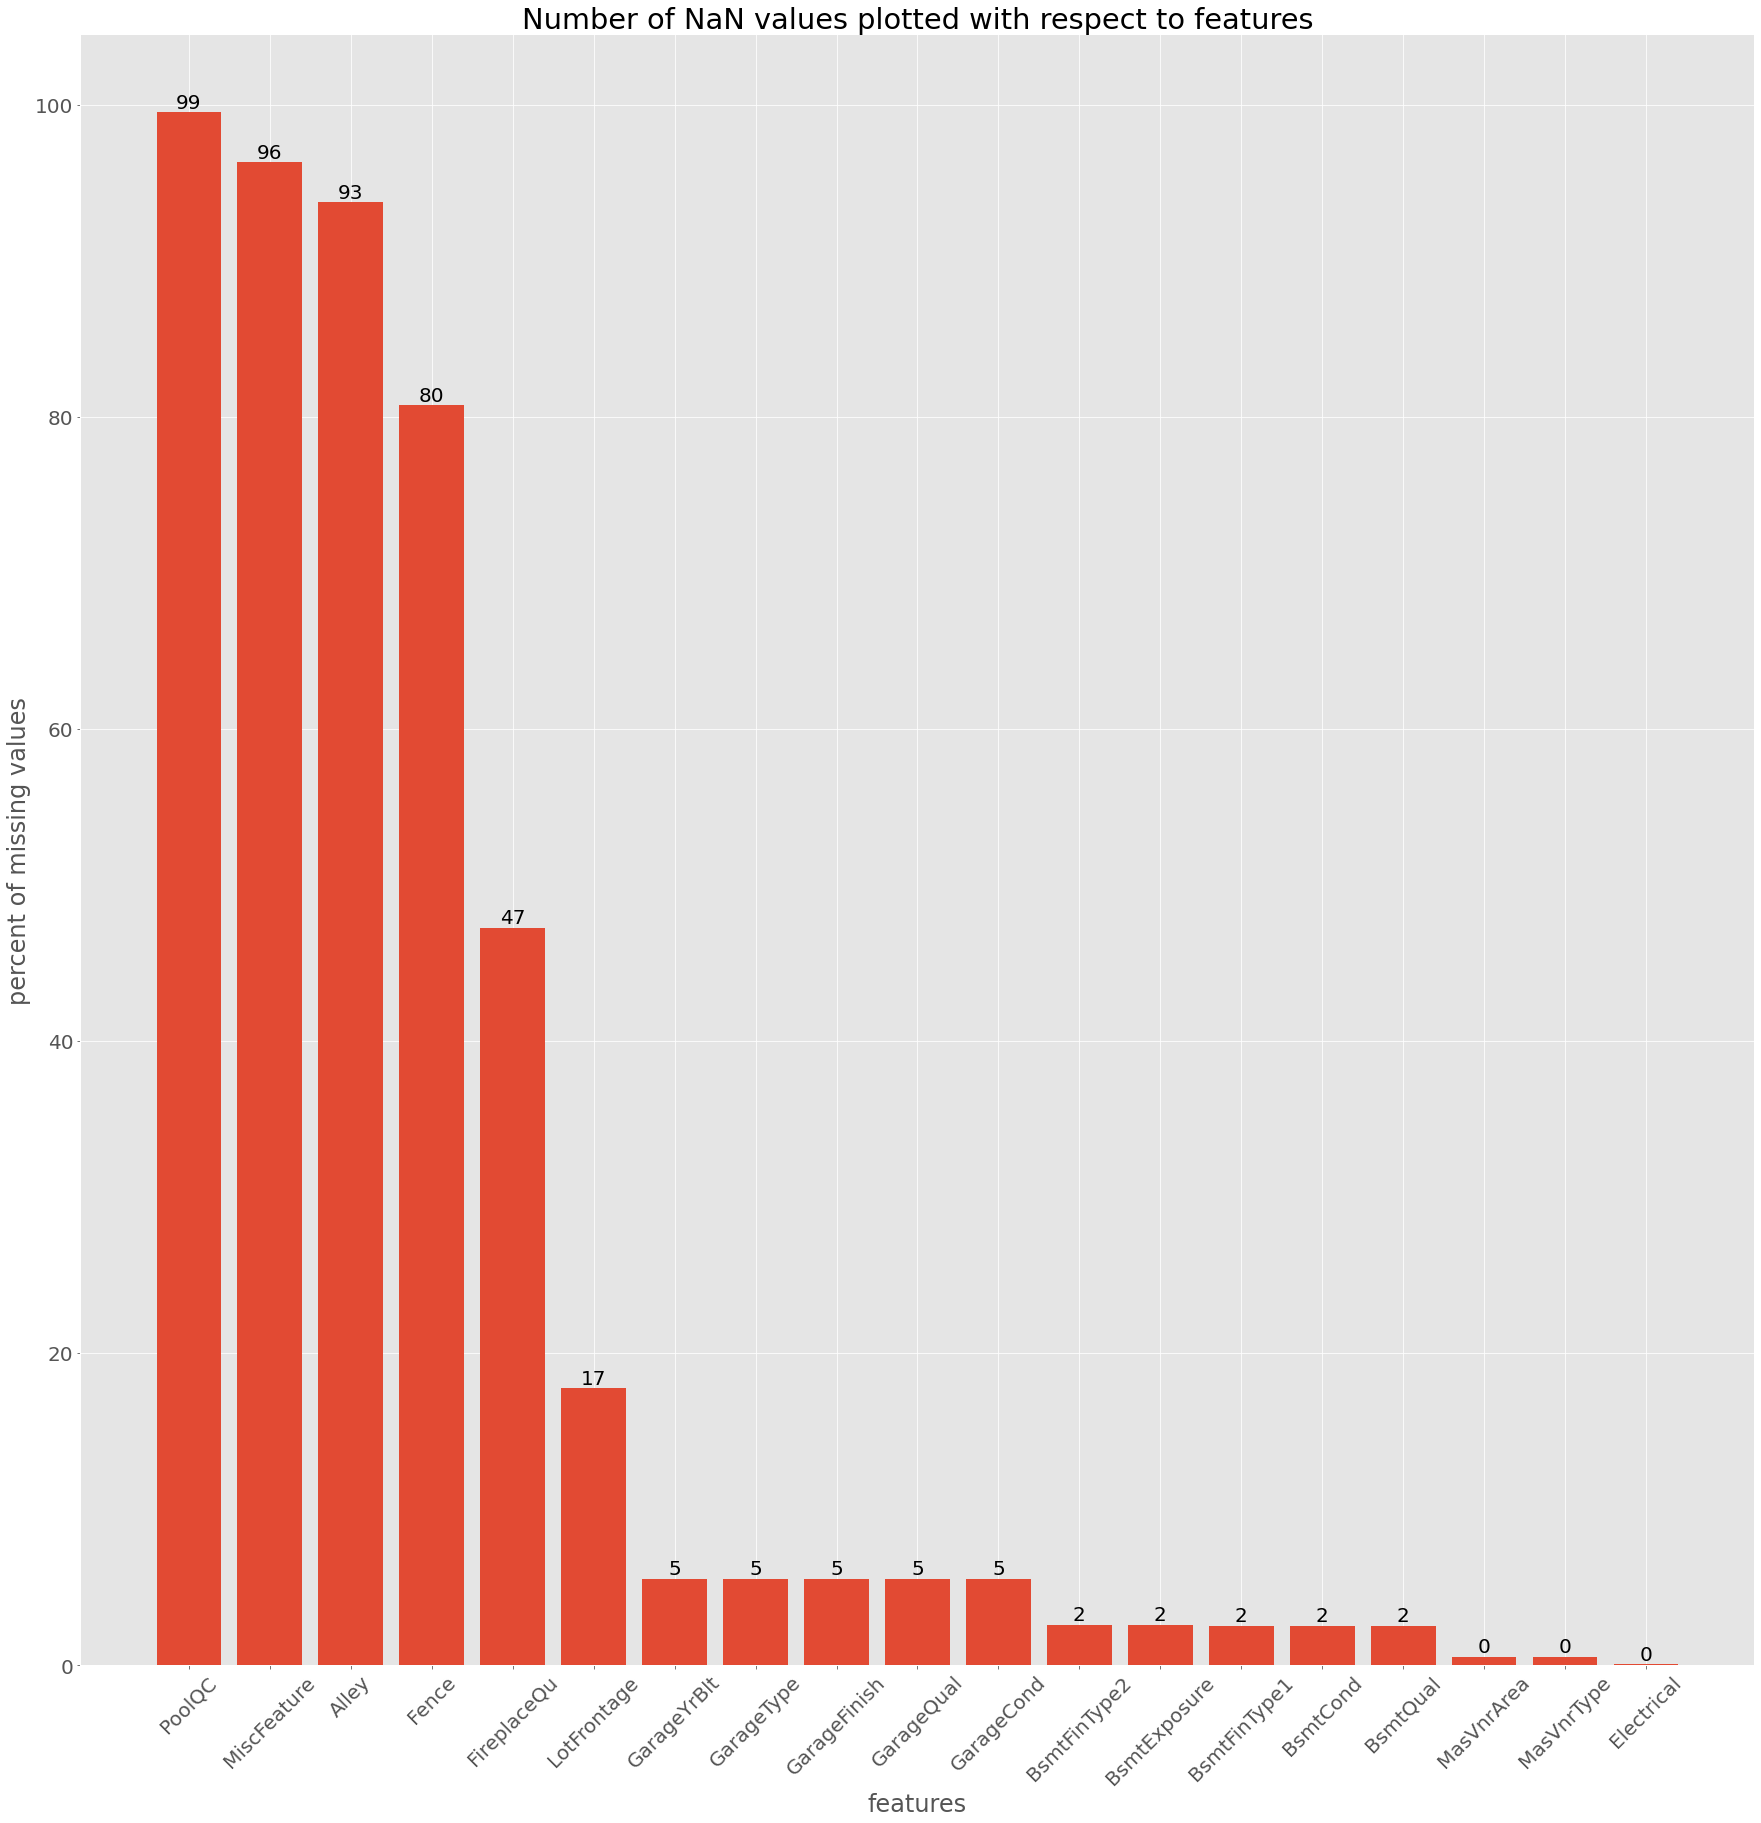

In [6]:
#plotting the missing values
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize = (30,30))
plt.title('Number of NaN values plotted with respect to features')
plt.xlabel('features')
plt.ylabel('percent of missing values')
plt.xticks(x,y.index, rotation = 45)
bar = plt.bar(x,y)
for bar1 in bar:
    height = bar1.get_height()
    plt.text(bar1.get_x()+bar1.get_width()/2,1.00*height,int(height),ha='center',va='bottom')
plt.show()


If you want to see just list:

In [7]:
y

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

**PoolQC**  - Pool quality

**MiscFeature** - Miscellaneous feature not covered in other categories

**Alley**  -  Type of alley access to property 

**Fence** - Fence: Fence quality

**FireplaceQu**  -  FireplaceQu: Fireplace quality 

all about garage: na  means that hours don't have garage:

**GarageYrBlt     
GarageType      
GarageFinish    
GarageQual      
GarageCond** 


In [8]:
#here we can see what colums are catigorial
for f in data.columns:
    if data[f].dtype=='object':
        print(f)


MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


**After reading  description of data we can see that some feachers are obviously ordinal. That's why I decide to encode these feachers manually. For other feachers i decide to use encorder.**

In [9]:
list_for_encoder = ['HouseStyle',
                    'MSZoning',
                    'Street',
                    'Utilities',
                    'LandContour',
                    'Neighborhood',
                    'Condition1',
                    'Condition2',
                    'BldgType',
                    'RoofStyle',
                    'RoofMatl',
                    'MasVnrType',
                    'Exterior1st',
                    'Exterior2nd',
                   'Foundation',
                    'Heating',
                    'CentralAir',
                    'Electrical',
                    'GarageType',
                    'SaleType',
                    'SaleCondition'

                    ]
                


In [10]:
dct = {'Ex':4, 
       'Gd':3,
       'TA':2, 
       'Fa':1,
       'NA':0}
data ['PoolQC'] = data['PoolQC'].map(dct)

dct = {'Grvl':1,
      'Pave':1}
data['Alley'] = data['Alley'].map(dct)

dct = {'Elev':1,
       'Gar2':1,
       'Othr':1,
       'Shed':1,
       'TenC':1}
data['MiscFeature'] = data['MiscFeature'].map(dct)

dct = {'GdPrv':4,
       'MnPrv':3,
       'GdWo':2,
       'MnWw':1}

data['Fence'] = data['Fence'].map(dct)

dct = {'Reg': 1,
      'IR1':2,
      'IR2':3,
      'IR3':4}
data['LotShape'] = data['LotShape'].map(dct)


dct = {'Inside':1,
       'Corner':2,
       'CulDSac':3,
       'FR2':4,
       'FR3':5}
data['LotConfig'] = data['LotConfig'].map(dct)


dct = {'Gtl':1,
      'Mod':2,
      'Sev':3}
data['LandSlope'] = data['LandSlope'].map(dct)


dct = {'Ex': 5,
      'Gd':4,
      'TA':3,
      'Fa':2,
      'Po':1}
data['ExterQual'] = data['ExterQual'].map(dct)
data['ExterCond'] = data ['ExterCond'].map(dct)
data['BsmtQual'] = data['BsmtQual'].map(dct)
data['BsmtCond'] = data['BsmtCond'].map(dct)
data['HeatingQC'] = data['HeatingQC'].map(dct)
data['KitchenQual'] = data['KitchenQual'].map(dct)
data['FireplaceQu'] = data['FireplaceQu'].map(dct)
data['GarageQual'] = data['GarageQual'].map(dct)
data['GarageCond'] = data['GarageCond'].map(dct)

dct = {'GLQ':6,
      'ALQ':5,
      'BLQ':4,
      'Rec':3,
      'LwQ':2,
      'Unf':1}
data['BsmtFinType1'] = data['BsmtFinType1'].map(dct)
data['BsmtFinType2'] = data['BsmtFinType2'].map(dct)


dct = {'Gd':4,
      'Av':3,
      'Mn':2,
      'No':1}
data['BsmtExposure'] = data['BsmtExposure'].map(dct)

dct = { 'Sal':1,
       'Sev':2,
       'Maj2':3,
       'Maj1':4,
       'Mod': 5, 
       'Min2':6,
       'Min1':7,
       'Typ':8
      }
data['Functional'] = data['Functional'].map(dct)

dct = {'Fin':3 ,
      'RFn':2,
      'Unf':1}
data['GarageFinish'] = data['GarageFinish'].map(dct)

dct = { 'Y':2,
       'P':1,
       'N':0}
data['PavedDrive'] = data['PavedDrive'].map(dct)



**What about other categorial feachers? Frankly speaking, I don't know what can be better: one hot encoder or Label Encoding. We can do research.**

In [11]:
data = pd.get_dummies (data, prefix_sep = '_', drop_first = True)
data.head ()

,Id,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LotConfig,LandSlope,OverallQual,OverallCond,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,NaN,1,1,1,7,5,...,0,0,0,0,1,0,0,0,1,0
1,2,20,80.0,9600,NaN,1,4,1,6,8,...,0,0,0,0,1,0,0,0,1,0
2,3,60,68.0,11250,NaN,2,1,1,7,5,...,0,0,0,0,1,0,0,0,1,0
3,4,70,60.0,9550,NaN,2,2,1,7,5,...,0,0,0,0,1,0,0,0,0,0
4,5,60,84.0,14260,NaN,2,4,1,8,5,...,0,0,0,0,1,0,0,0,1,0


**When we start analazying missing values, We can see that in most cases missing values are not mistake. For example, missing value in PoolQl column means that house doesn't have pool. And other Na-values we can explain same way.**

In [12]:
data = data.fillna(0)

### XGboost

XGbooost is faster then other algorithm compositions. It often shows best results in Kaggle competitions. And it can work with 
nonlinear regression. 

In [ ]:
#1step delete id. There is no information in this column
data.drop(['Id'], axis = 1, inplace = True )

In [18]:
data.head()

,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LotConfig,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,0.0,1,1,1,7,5,2003,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,0.0,1,4,1,6,8,1976,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,0.0,2,1,1,7,5,2001,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,0.0,2,2,1,7,5,1915,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,0.0,2,4,1,8,5,2000,...,0,0,0,0,1,0,0,0,1,0


In [19]:
X = data.drop(['SalePrice'],axis=1)
y = data.SalePrice
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
max_depth = [2, 4, 6,8]
n_estimators = [50, 100, 150, 200]
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model,
                   {'max_depth':max_depth ,
                    'n_estimators': n_estimators },cv=kfold, verbose=1, n_jobs=1)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)



Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.2min finished


0.8734221364588576
{'max_depth': 2, 'n_estimators': 200}


Let's visuilize Greed Search:


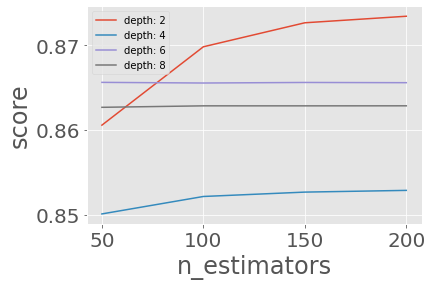

In [20]:
means = clf.cv_results_['mean_test_score']
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
    plt.legend(loc=2, prop={'size': 10})
    plt.xlabel('n_estimators')
    plt.ylabel('score')



In [21]:
model = Lasso()
alpha = [0.1,0.5,1,2,3,5,7,10,12,15,20,50,100,200,250,300]
lin_mod = GridSearchCV(model,param_grid={'alpha':alpha},cv=kfold, verbose=1, n_jobs=1)
lin_mod.fit(X, y)
print(lin_mod.best_score_)
print(lin_mod.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   12.2s finished


0.8128324222653683
{'alpha': 200}


Text(0, 0.5, 'score')

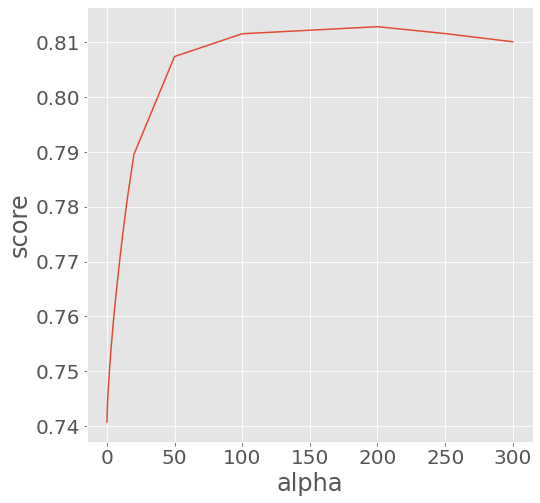

In [22]:
plt.figure(figsize=(8, 8))
means = lin_mod.cv_results_['mean_test_score']

plt.plot(alpha, means)
plt.xlabel('alpha')
plt.ylabel('score')


**Summary:**

    For competition I would choose XGboost, LinearRegression is faster, but shows not such good results.